In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load the dataset
data_time = pd.read_csv("E:/2024/July2024/Fault_Classification/Dataset/feature_time_48k_2048_load_1.csv")

# Scale each column to have zero mean and standard deviation equal to 1
scaler = StandardScaler()
train_data, test_data = train_test_split(data_time, test_size=750, stratify=data_time['fault'], random_state=1234)

# Scale the training data
train_data_scaled = scaler.fit_transform(train_data.iloc[:, :-1])
train_data_scaled = torch.tensor(train_data_scaled, dtype=torch.float32)

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_data['fault'])
train_labels = torch.tensor(train_labels_encoded, dtype=torch.int64)  # Use dtype=torch.int64 for labels

# Scale the testing data
test_data_scaled = (test_data.iloc[:, :-1].values - scaler.mean_) / np.sqrt(scaler.var_)
test_data_scaled = torch.tensor(test_data_scaled, dtype=torch.float32)

test_labels_encoded = label_encoder.transform(test_data['fault'])
test_labels = torch.tensor(test_labels_encoded, dtype=torch.int64)  # Use dtype=torch.int64 for labels

# Define the Siamese Network
class SiameseNetwork(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SiameseNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return x

# Define the Contrastive Loss
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = torch.nn.functional.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                      label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

# Create pairs of data
def create_pairs(data, labels):
    pairs = []
    labels_list = []
    num_classes = len(np.unique(labels))
    class_indices = [np.where(labels == i)[0] for i in range(num_classes)]
    for idx1 in range(len(data)):
        current_class = labels[idx1]
        idx2 = np.random.choice(class_indices[current_class])
        pairs += [[data[idx1], data[idx2]]]
        labels_list += [1]
        negative_class = (current_class + np.random.randint(1, num_classes)) % num_classes
        idx2 = np.random.choice(class_indices[negative_class])
        pairs += [[data[idx1], data[idx2]]]
        labels_list += [0]
    return np.array(pairs), np.array(labels_list)

train_pairs, train_labels = create_pairs(train_data_scaled.numpy(), train_labels.numpy())
test_pairs, test_labels = create_pairs(test_data_scaled.numpy(), test_labels.numpy())

class PairsDataset(Dataset):
    def __init__(self, pairs, labels):
        self.pairs = pairs
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        sample = {'data1': torch.tensor(self.pairs[idx][0], dtype=torch.float32),
                  'data2': torch.tensor(self.pairs[idx][1], dtype=torch.float32),
                  'label': torch.tensor(self.labels[idx], dtype=torch.float32)}
        return sample

batch_size = 32
train_dataset = PairsDataset(train_pairs, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = PairsDataset(test_pairs, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, loss function, and optimizer
input_size = train_data_scaled.shape[1]
hidden_size = 128

model = SiameseNetwork(input_size, hidden_size)
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        data1, data2, labels = batch['data1'], batch['data2'], batch['label']

        optimizer.zero_grad()

        output1 = model(data1)
        output2 = model(data2)
        loss = criterion(output1, output2, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

# Evaluate the model on test data
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch in test_loader:
        data1, data2, labels = batch['data1'], batch['data2'], batch['label']
        output1 = model(data1)
        output2 = model(data2)
        euclidean_distance = torch.nn.functional.pairwise_distance(output1, output2)
        predicted = (euclidean_distance < 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Accuracy on test set: {accuracy}")


ModuleNotFoundError: No module named 'torch'

Epoch 1/50, Loss: 0.3410421069135371
Epoch 2/50, Loss: 0.30305279484114694
Epoch 3/50, Loss: 0.293806562104176
Epoch 4/50, Loss: 0.285330080340818
Epoch 5/50, Loss: 0.2816513478755951
Epoch 6/50, Loss: 0.2772822015986
Epoch 7/50, Loss: 0.2766282334155643
Epoch 8/50, Loss: 0.2709374592169044
Epoch 9/50, Loss: 0.27099160419911456
Epoch 10/50, Loss: 0.2690169560847823
Epoch 11/50, Loss: 0.26789448310419456
Epoch 12/50, Loss: 0.2659554927004981
Epoch 13/50, Loss: 0.2628398632880339
Epoch 14/50, Loss: 0.2611373564631669
Epoch 15/50, Loss: 0.26154286084101375
Epoch 16/50, Loss: 0.2592879735010186
Epoch 17/50, Loss: 0.2580589956229495
Epoch 18/50, Loss: 0.2570405054030959
Epoch 19/50, Loss: 0.2570299547664898
Epoch 20/50, Loss: 0.25340232990451694
Epoch 21/50, Loss: 0.25159297069323433
Epoch 22/50, Loss: 0.25311404451267006
Epoch 23/50, Loss: 0.25125648096664666
Epoch 24/50, Loss: 0.25081472544325994
Epoch 25/50, Loss: 0.24990456405374192
Epoch 26/50, Loss: 0.24953115462642356
Epoch 27/50, Lo

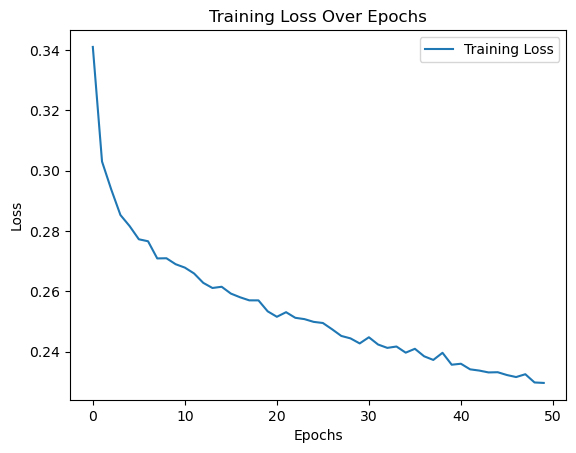

Accuracy on test set: 0.5086666666666667

Classification Report:
                 precision    recall  f1-score   support

Different Class       0.51      0.48      0.50       750
     Same Class       0.51      0.53      0.52       750

       accuracy                           0.51      1500
      macro avg       0.51      0.51      0.51      1500
   weighted avg       0.51      0.51      0.51      1500



In [ ]:
#!/usr/bin/env python
# coding: utf-8

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report

# Load the dataset
data_time = pd.read_csv("C:/Users/OKOK PRO/Downloads/CODE_Fault_Classification/Dataset/feature_time_48k_2048_load_1.csv")

# Scale each column to have zero mean and standard deviation equal to 1
scaler = StandardScaler()
train_data, test_data = train_test_split(data_time, test_size=750, stratify=data_time['fault'], random_state=1234)

# Scale the training data
train_data_scaled = scaler.fit_transform(train_data.iloc[:, :-1])
train_data_scaled = torch.tensor(train_data_scaled, dtype=torch.float32)

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_data['fault'])
train_labels = torch.tensor(train_labels_encoded, dtype=torch.int64)  # Use dtype=torch.int64 for labels

# Scale the testing data
test_data_scaled = (test_data.iloc[:, :-1].values - scaler.mean_) / np.sqrt(scaler.var_)
test_data_scaled = torch.tensor(test_data_scaled, dtype=torch.float32)

test_labels_encoded = label_encoder.transform(test_data['fault'])
test_labels = torch.tensor(test_labels_encoded, dtype=torch.int64)  # Use dtype=torch.int64 for labels

# Define the Siamese Network
class SiameseNetwork(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SiameseNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return x

# Define the Contrastive Loss
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = torch.nn.functional.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                      label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

# Create pairs of data
def create_pairs(data, labels):
    pairs = []
    labels_list = []
    num_classes = len(np.unique(labels))
    class_indices = [np.where(labels == i)[0] for i in range(num_classes)]
    for idx1 in range(len(data)):
        current_class = labels[idx1]
        idx2 = np.random.choice(class_indices[current_class])
        pairs += [[data[idx1], data[idx2]]]
        labels_list += [1]
        negative_class = (current_class + np.random.randint(1, num_classes)) % num_classes
        idx2 = np.random.choice(class_indices[negative_class])
        pairs += [[data[idx1], data[idx2]]]
        labels_list += [0]
    return np.array(pairs), np.array(labels_list)

train_pairs, train_labels = create_pairs(train_data_scaled.numpy(), train_labels.numpy())
test_pairs, test_labels = create_pairs(test_data_scaled.numpy(), test_labels.numpy())

class PairsDataset(Dataset):
    def __init__(self, pairs, labels):
        self.pairs = pairs
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        sample = {'data1': torch.tensor(self.pairs[idx][0], dtype=torch.float32),
                  'data2': torch.tensor(self.pairs[idx][1], dtype=torch.float32),
                  'label': torch.tensor(self.labels[idx], dtype=torch.float32)}
        return sample

batch_size = 32
train_dataset = PairsDataset(train_pairs, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = PairsDataset(test_pairs, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, loss function, and optimizer
input_size = train_data_scaled.shape[1]
hidden_size = 128

model = SiameseNetwork(input_size, hidden_size)
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 50
losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        data1, data2, labels = batch['data1'], batch['data2'], batch['label']

        optimizer.zero_grad()

        output1 = model(data1)
        output2 = model(data2)
        loss = criterion(output1, output2, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}")

# Plot the loss over epochs
plt.plot(range(num_epochs), losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Evaluate the model on test data
model.eval()
correct = 0
total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for batch in test_loader:
        data1, data2, labels = batch['data1'], batch['data2'], batch['label']
        output1 = model(data1)
        output2 = model(data2)
        euclidean_distance = torch.nn.functional.pairwise_distance(output1, output2)
        predicted = (euclidean_distance < 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

accuracy = correct / total
print(f"Accuracy on test set: {accuracy}")

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Different Class", "Same Class"]))
